# FinalCapstone_5_Analysis

This is a notebook that contains the analysis for the first part of "What is the best neighbourhood to live in as a student at Imperial College London?" (*link:* https://github.com/namiyousef/Coursera_Capstone).

**NOTE:** if you are a peer examiner from the IBM Coursera course (IBM Applied Data Science Capstone), please only mark this notebook, and the relevant parts of the report. At this current time, I will not be able to complete the second part of the project (stated in my report).

Note that the scope of this project was far greater than that required by the IBM Course, in particular with regards to the volume of data. The previous notebooks deal with different data sources and reach the conclusion that **crime** and **demographics** cannot be considered as part of the analysis, as initially stated on the project proposal.

With that in mind, this notebook contains the data exploration and cleaning, modelling and evaluation.

**Structure of the notebook:**
0. Libraries needed, configuration
1. Data attainment, cleaning and exploration
2. Data visualisation
3. Modelling
4. Evaluation
5. Final results
6. Conclusion

# 0 - Libraries needed, configuration

In [50]:
""" Libraries """

# file management and web scraping

#import os
#import urllib.request
#try: 
  #  from BeautifulSoup import BeautifulSoup
#except ImportError:
 #   from bs4 import BeautifulSoup

import json

# mathematical

# data exploration
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.cm as cm
#import folium
from geopy.geocoders import Nominatim

# preprocessing

# modelling

# evaluation

""" Configuration """

# pandas
pd.set_option('display.max_columns', None)

# matplotlib
plt.style.use('classic')

# 1. Data Attainment, Cleaning and Exploration

## Cleaning rent data

In [7]:
df_rent = pd.read_csv(('/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/Courses'
        '/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/Data/df_rent.csv'),index_col = 0)
# the data for df_rent has attained from rentbarometer in the FinalCapstone_1_ClusteringNeighbourhoods where web 
# sraping was used (using the BeautifulSoup library)

In [8]:
df_rent.head()

,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist
0,Bromley,NaN,263.0,287.0,381.0,498.0,NaN,BR1
1,Croyon,197.0,280.0,355.0,NaN,NaN,NaN,CR0
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,NaN,E2
3,Bow,NaN,313.0,371.0,481.0,612.0,637.0,E3
4,Canary Wharf,405.0,507.0,585.0,719.0,NaN,NaN,E14


As seen above, there are many NaN values. Instead of removing these, let's replace them with either the mean or median values. For this, we need to see the distributions of prices in each column first!

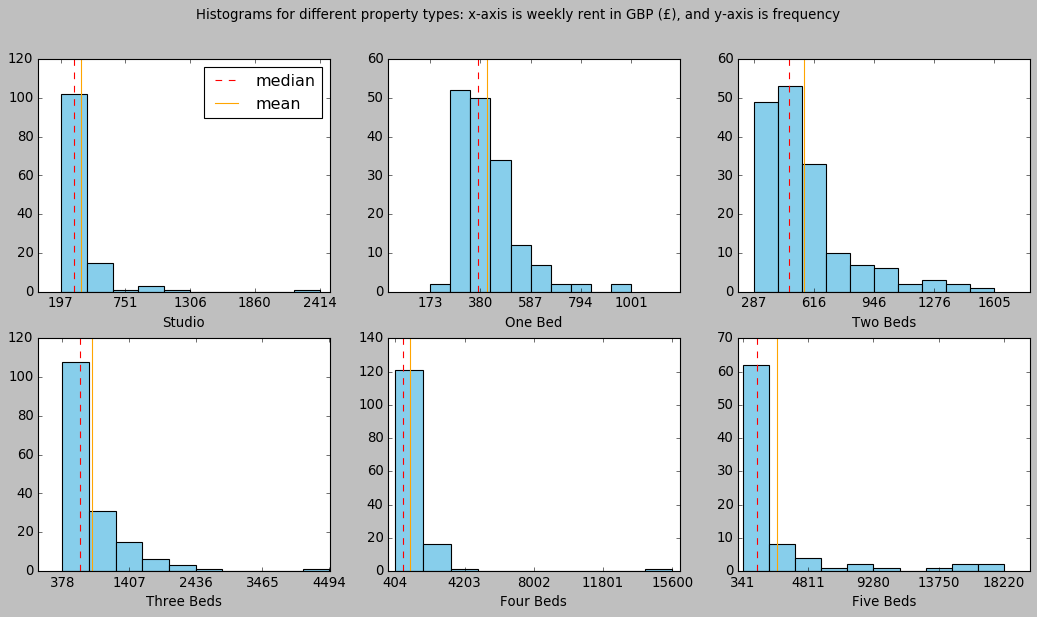

In [9]:
columns = df_rent.columns.values.tolist()[1:-1]
fig = plt.figure(figsize = (16,8))
plt.suptitle('Histograms for different property types: x-axis is weekly rent in GBP (£), and y-axis is frequency')
for index,column in enumerate(columns):
    fig.add_subplot(2,3,index+1)
    df_temp = df_rent[column]
    df_temp.dropna(axis = 0,inplace = True)
    plt.hist(df_temp,color = 'skyblue')
    plt.axvline(x = df_temp.median(),linestyle = '--',color = 'r')
    plt.axvline(x = df_temp.mean(),linestyle = '-',color = 'orange')
    plt.xticks(np.linspace(df_temp.min(),df_temp.max(),5))
    if index == 0:
        plt.legend(['median','mean'])
    plt.xlabel(column)

Seeing as for for the most part, the median seems to be more reliable... it was decidecd to replace the np.nan values with the median!

In an ideal case, one would first, as part of the preprocessing, ensure that neighbourhoods are first clustered by the average property prices (i.e. cheaper ones would be clustered together, more expensive ones in another cluster, then for each cluster, the median will be used to fill that certain cluster). This would be interesting to add for the next iteration of this project.

In [48]:
for i, column in enumerate(columns):
    df_rent[column] = df_rent[column].fillna(df_rent[column].median())
    
print(df_rent.shape)
df_rent.head()

(174, 8)


,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist
0,Bromley,313.0,263.0,287.0,381.0,498.0,1300.0,BR1
1,Croyon,197.0,280.0,355.0,654.0,803.0,1300.0,CR0
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,1300.0,E2
3,Bow,313.0,313.0,371.0,481.0,612.0,637.0,E3
4,Canary Wharf,405.0,507.0,585.0,719.0,803.0,1300.0,E14


## Finding close supermarkets, restaurants and nightlife

In [47]:
# path to .json file containing Foursquare credentials

path = ("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
        "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/config.json")

with open(path, 'r') as f:
    config = json.load(f)

# configure the foursquare API rules
CID = config['foursquare']['CID']
CSecret = config['foursquare']['CID']
CategoryID = '4d4b7105d754a06374d81259'
version = '20180604'
limit = 50 # maximum limit allowed by foursquare [1]
latitude = ''
longitude = ''

# setting up a query for formatting the foursquare URL
query = {
    'CID':CID,
    'CSecret':CSecret,
    'CategoryID':CategoryID,
    'version': version,
    'limit':limit,
    'lat':latitude,
    'long':longitude
}

# categories that we are interested in searching, with their correct foursquare ID's [2]
categories = {
    'restaurants':'4d4b7105d754a06374d81259',
    'grocery': '4bf58dd8d48988d1f9941735',
    'nightlife': '4d4b7105d754a06376d81259',
    'entertainment': '4d4b7104d754a06370d81259',
    'outdoors': '4d4b7105d754a06377d81259'
}

# testing that everything works
url = ('https://api.foursquare.com/v2/venues/search?categoryId={CategoryID}&'
       'client_id={CID}'
       '&client_secret={CSecret}'
       '&ll={lat},{long}'
       '&v={version}'
       '&limit={limit}'
      ).format(**query)

In [ ]:
# london geodata {from source:[3]}

london_geodata = 

def plot_map():
    

In [55]:
""" ONLY RUN THIS CELL WHEN NECESSARY TO CONSERVE API CALLS! """

geolocator = Nominatim(user_agent="foursquare_agent")


for postal_district in df_rent.PostDist.unique():
    location = geolocator.geocode('{}, London, England, United Kingdom'.format(postal_district))
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)

51.5073219 -0.1276474
51.3713618 -0.1111235
51.5073219 -0.1276474
51.5073219 -0.1276474
51.5073219 -0.1276474
51.5073219 -0.1276474
51.5073219 -0.1276474
51.5073219 -0.1276474
51.5073219 -0.1276474


KeyboardInterrupt: 

# Conclusion

# References

1. https://stackoverflow.com/questions/45992235/foursquare-api-get-filtered-list-of-restaurants
2. https://developer.foursquare.com/docs/build-with-foursquare/categories/
3. https://github.com/sjwhitworth/london_geojson/blob/master/london_postcodes.json


